# Importing Libraries


In [ ]:
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from collections import deque
from keras.models import load_model
from keras.optimizers import Adam

In [ ]:
tf.test.gpu_device_name()

''

# Data Manipulation Functions

In [ ]:
# sigmoid function was used to put the data in the range of [0,1]
def sigmoid(x):
    return 1/(1+math.exp(-x))
# takes the csv file_name and returns the prices in y_train, and transformed data to be used as input in x_train
def manip_data(name,n):
  df= pd.read_csv(name, index_col="Date")
  df.drop(['Open','High','Low',"Close",'Volume'],axis=1,inplace=True)

  length=100
  training_set=df.to_numpy()
  training_length=len(training_set)
  #training_length=100
  period=n
  x_train=[]
  y_train=[]
  # I used the prices of day t and 4 days before it to get 4 consc changes in price and applied sigmoid on it
  for i in range(period,training_length):
          temp=[]
          y_train.append(training_set[i])
          for p in range(period):
            temp.append(sigmoid(training_set[i-period+p+1][0] - training_set[i-period+p][0]))
          x_train.append(temp)
  x_train=np.array(x_train)
  x_train=np.reshape(x_train,(x_train.shape[0],1,period))
  y_train=np.array(y_train)
  return (x_train,y_train)

def formatPrice(n):
    return("-Rs." if n<0 else "Rs.")+"{0:.2f}".format(abs(n))

# The DQN Class

In [ ]:
class DQN:
  def __init__(self,state_size,done=False,model_name=""):
    self.done=done
    self.action_size=3
    self.state_size=state_size
    self.memory= deque(maxlen=1000)
    #List of amount invested in the stock since last sell
    self.buying_price=[]
    self.gamma = 0.97
    self.epsilon = 1.0
    self.epsilon_min = 0.05
    self.epsilon_decay = 0.995
    #No of batches after which target network is updated
    self.update=20
    self.model = load_model(model_name) if done else self._model()
    if not done:
      self.target_network= self._target_network()

  def _model(self):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=16, input_dim=self.state_size, activation='relu'))
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=3, activation='linear'))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    return model

  def _target_network(self):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units=16, input_dim=self.state_size, activation='relu'))
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=3, activation='linear'))
    model.compile(loss="mse", optimizer=Adam(lr=0.001))
    model.set_weights(self.model.get_weights())
    return model

  def act(self, state):
    state=np.reshape(state,(1,-1))
    if not self.done and random.random()<= self.epsilon:
        return random.randrange(self.action_size)
    options = self.model.predict(state)
    return np.argmax(options[0])

  def expReplay(self, batch_size, count):
        mini_batch = []
        l = len(self.memory)
        # start= random.randint(0,l-batch_size)
        #training the model over the last (batch_size) trades, picking randomly just didnt seem to work
        for i in range(l-batch_size,l):
          mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
          state=np.reshape(state,(1,-1))
          next_state=np.reshape(next_state,(1,-1))
          target = reward
          # The bellman equation
          if not done:
              target = reward + self.gamma * np.amax(self.target_network.predict(next_state)[0])
          target_f = self.model.predict(state)
          target_f[0][action] = target
          self.model.fit(state, target_f, epochs=1, verbose=0)

        #decreasing exploration probability
        if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
        #updating the target_network
        if count%self.update==0:
          self.target_network.set_weights(self.model.get_weights())

# Training Block

In [ ]:
max_transc=5
money= 20000
curr_transc=0
stocks=0
total_profit=0
batch_size=10
agent= DQN(5,False,"/content/drive/MyDrive/Colab Notebooks/DQN_slow_buy2")
x_train,y_train= manip_data("/GOOG (3).csv",4)
episode_count=150
code={0:'b',1:'g',2:'r'}

#The model was trained on the stock price of google over four months
#Training takes roughly 2hrs to get a "Good" model
for e in range(episode_count + 1):
  print("Episode " + str(e) + "/" + str(episode_count))
  total_profit = 0
  money=20000
  curr_transc=0
  stocks=0
  i=0
  agent.buying_price=[]
  decisions=[]
  state=x_train[0]
  count=0
  for t in range (x_train.shape[0]-1):
    price= float(y_train[t][0])
    #state contains the manipulated prices of the last 4 days and a variable representing no of transactions we can do
    if t==0:
      state=np.append(state,[1])
    action=agent.act(state)
    if (t!= len(x_train)-1):
      next_state=x_train[t+1]

    reward=0
    decisions.append(code[action])
    #very small rewards for holding and buying at the righ time, high rewards for good sales
    # if action==0 and price>= float(y_train[t+1][0]):
    #   reward=0.015

    elif action ==1 and curr_transc < max_transc: #buy
      total_buy= money/(max_transc-curr_transc)
      shares= int(total_buy/price)
      # print("Buy:",shares*price)
      agent.buying_price.append(shares*price)
      money= money- shares*price
      curr_transc+= 1
      stocks+=shares
      if price < float(y_train[t+1][0]):
        reward=0.015

    elif action==2 and curr_transc>0:
      price= float(y_train[t][0])
      sell= stocks*price
      buy=0
      while (len(agent.buying_price)):
        buy=buy + agent.buying_price.pop()
      profit=sell-buy
      # print("Sell:",sell)
      money+=sell
      total_profit+=profit
      curr_transc=0
      stocks=0
      reward=100*(max(profit,0)/buy)
      # print("--------------------------------")
      # print("Profit: " + formatPrice(profit))
      # print("--------------------------------")
    var=(max_transc-curr_transc)/max_transc
    next_state=np.append(next_state,[var])
    done= True if t== x_train.shape[0]-2 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
    if len(agent.memory) > batch_size:
      agent.expReplay(batch_size,count)
      count+=1
  #Plotting the stock price, colur coded according to the action of the agent
  plt.figure(figsize=(10,10))
  for j in range(len(y_train)-1):
   plt.scatter(j,y_train[j],color=decisions[j])
  plt.show()
  agent.model.save(str(e))

SyntaxError: ignored

# Testing Blocks and Final Results

Strategy for /AAPL (1).csv:--------------------------------
Total Profit: Rs.6281.92


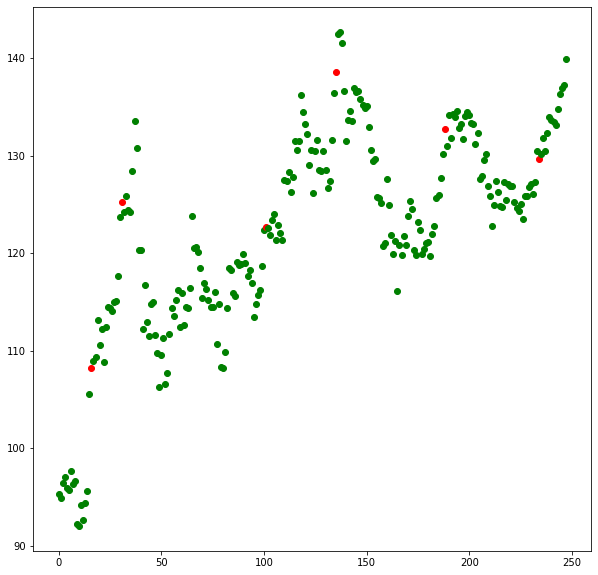

Strategy for /TATAMOTORS.NS.csv:--------------------------------
Total Profit: Rs.32541.70


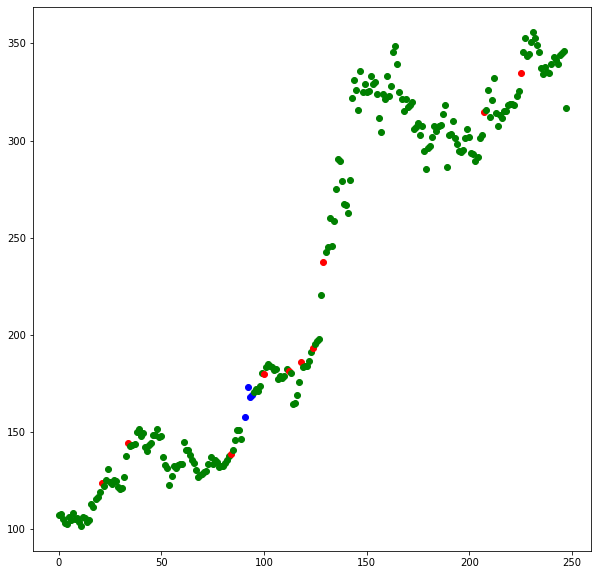

Strategy for /RUPA.NS.csv:--------------------------------
Total Profit: Rs.19650.34


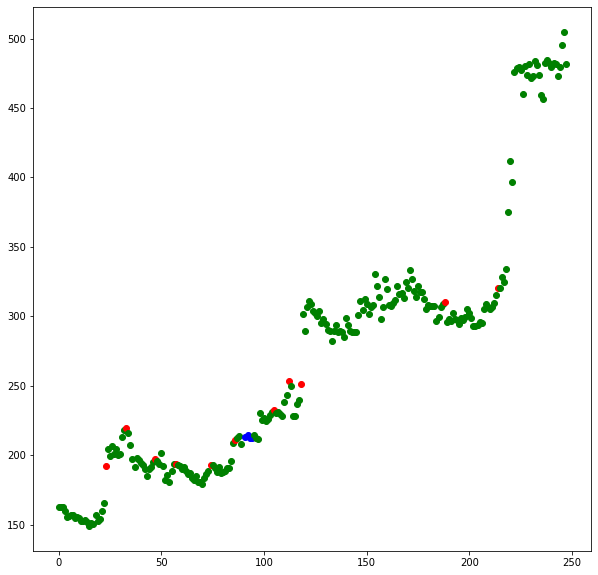

Strategy for /GOOG (3).csv:--------------------------------
Total Profit: Rs.12563.74


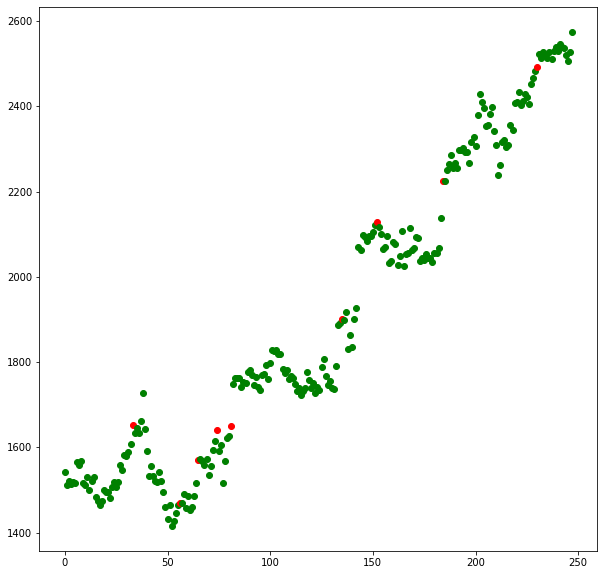

Strategy for /CENTURYTEX.NS.csv:--------------------------------
Total Profit: Rs.13931.89


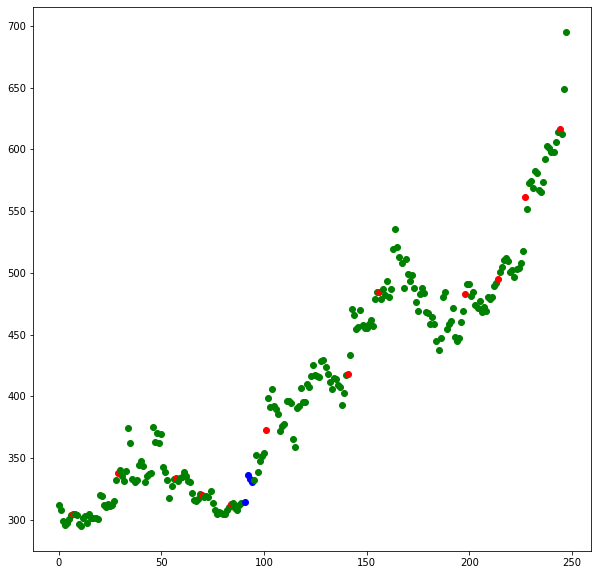

Strategy for /ATGL.NS.csv:--------------------------------
Total Profit: Rs.144264.94


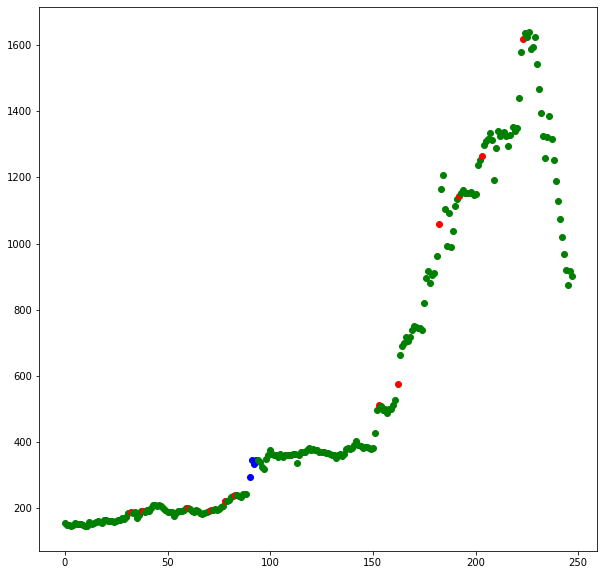

Strategy for /AMZN (2).csv:--------------------------------
Total Profit: Rs.6014.11


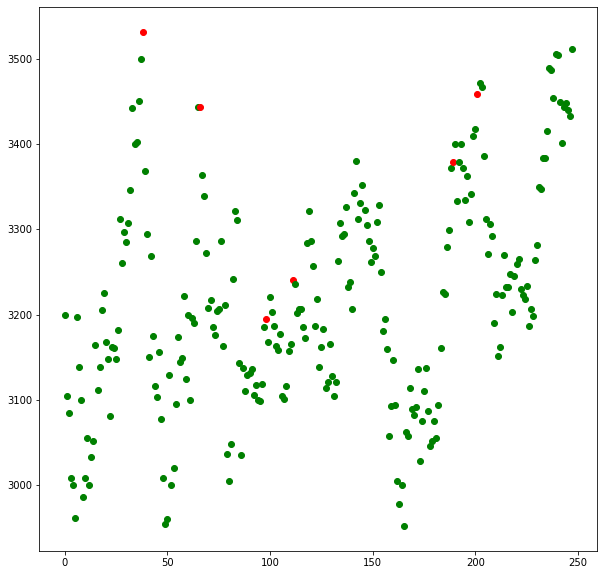

In [ ]:
# we run the model on the yearly data of a few companies
paths={"/ATGL.NS.csv","/AAPL (1).csv","/AMZN (2).csv","/CENTURYTEX.NS.csv","/GOOG (3).csv","/RUPA.NS.csv","/TATAMOTORS.NS.csv"}
for i in paths:
  x_train,y_train= manip_data(i,4)
  print("Strategy for "+str(i)+":",end="")
  #calling the saved model
  agent= DQN(5,True,"/content/drive/MyDrive/Colab Notebooks/DQN_slow_buy")
  total_profit = 0
  money=20000
  curr_transc=0
  stocks=0
  agent.buying_price=[]
  state=x_train[0]
  state=np.append(state,[1])
  decisions=[]
  for t in range (x_train.shape[0]):
    price= float(y_train[t][0])
    action=agent.act(state)
    if (t!= len(x_train)-1):
      next_state=x_train[t+1]
    else:
      next_state= x_train[0]
    decisions.append(code[action])
    if action ==1 and curr_transc < max_transc: #buy
      total_buy= money/(max_transc-curr_transc)
      shares= int(total_buy/price)
      agent.buying_price.append(shares*price)
      money= money- shares*price
      curr_transc+= 1
      stocks+=shares

    elif action==2 and not curr_transc==0:
      price= float(y_train[t][0])
      sell= stocks*price
      buy=0
      while (len(agent.buying_price)):
        buy=buy + agent.buying_price.pop()
      profit=sell-buy
      money+=sell
      total_profit+=profit
      curr_transc=0
      stocks=0
    var=(max_transc-curr_transc)/max_transc
    next_state=np.append(next_state,[var])
    done= True if t== x_train.shape[0]-1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        # print("--------------------------------")
  #green:BUY, red:SELL, blue:HOLD
  #buying after reaching max_transaction limit is the same as holding
  plt.figure(figsize=(10,10))
  for j in range(len(y_train)):
    plt.scatter(j,y_train[j],color=decisions[j])
  plt.show()
  #The insanely high profit margins are partly due to the increasing trend over the past year
  #The model has a tendency to buy as soon as it sells, so the entry calls are really bad
  #The highly accurate exit calls, compensate the bad entry calls and hence the overall profit


Strategy for /AMZN.csv:--------------------------------
Total Profit: Rs.411941.81


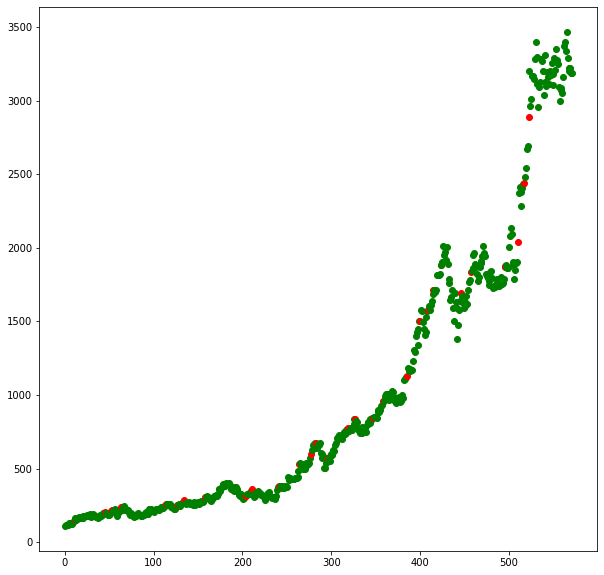

In [ ]:
#Running the model over weekly data of amazon over 10 yrs

# max_profit=0
# model=0
# we run the model on the yearly data of a few companies
i="/AMZN.csv"
x_train,y_train= manip_data(i,4)
print("Strategy for "+str(i)+":",end="")
#calling the saved model
agent= DQN(5,True,"/content/drive/MyDrive/Colab Notebooks/DQN_slow_buy")
total_profit = 0
money=20000
curr_transc=0
stocks=0
agent.buying_price=[]
state=x_train[0]
state=np.append(state,[1])
decisions=[]
for t in range (x_train.shape[0]):
  price= float(y_train[t][0])
  action=agent.act(state)
  if (t!= len(x_train)-1):
    next_state=x_train[t+1]
  else:
    next_state= x_train[0]
  decisions.append(code[action])
  if action ==1 and curr_transc < max_transc: #buy
    total_buy= money/(max_transc-curr_transc)
    shares= int(total_buy/price)
    agent.buying_price.append(shares*price)
    money= money- shares*price
    curr_transc+= 1
    stocks+=shares

  elif action==2 and not curr_transc==0:
    price= float(y_train[t][0])
    sell= stocks*price
    buy=0
    while (len(agent.buying_price)):
      buy=buy + agent.buying_price.pop()
    profit=sell-buy
    money+=sell
    total_profit+=profit
    curr_transc=0
    stocks=0
  var=(max_transc-curr_transc)/max_transc
  next_state=np.append(next_state,[var])
  done= True if t== x_train.shape[0]-1 else False
  agent.memory.append((state, action, reward, next_state, done))
  state = next_state

  if done:
      print("--------------------------------")
      print("Total Profit: " + formatPrice(total_profit))
      # print("--------------------------------")
# if total_profit>max_profit:
#   max_profit=total_profit
#   model=i
# this code was used to pick the best model we have found so far
plt.figure(figsize=(10,10))
for j in range(len(y_train)):
  plt.scatter(j,y_train[j],color=decisions[j])
plt.show()
#The insanely high profit margins are partly due to the increasing trend over the past year
#The model has a tendency to buy as soon as it sells, so the entry calls are really bad
#The highly accurate exit calls, compensate the bad entry calls and hence the overall profit
